In [ ]:
# ..... get annotations with SCimilarity ..... #

In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = [6, 4]

import warnings

warnings.filterwarnings("ignore")

/home/suresh/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellAnnotation

In [5]:
# Instantiate the CellAnnotation object
# Set model_path to the location of the uncompressed model
model_path = "/home/suresh/septation/markers/scimilarity/models/annotation_model_v1"
ca = CellAnnotation(model_path=model_path)

In [8]:
# Load heart sample data
data_path = "stage23_sample3_scimilarity.h5ad"
adams = sc.read(data_path)

# add counts layer manually
adams.layers["counts"] = adams.X

In [9]:
# fix gene-order
adams = align_dataset(adams, ca.gene_order)

In [13]:
# normalize
adams = lognorm_counts(adams)

In [15]:
# compute embeddings
adams.obsm["X_scimilarity"] = ca.get_embeddings(adams.X)

In [18]:
# get UMAP
sc.pp.neighbors(adams, use_rep="X_scimilarity")
sc.tl.umap(adams)

In [17]:
# unconstrained anno
predictions, nn_idxs, nn_dists, nn_stats = ca.get_predictions_kNN(
    adams.obsm["X_scimilarity"]
)
adams.obs["predictions_unconstrained"] = predictions.values

Get nearest neighbors finished in: 0.0019482056299845378 min


100%|████████████████████████████████████████████████████| 8453/8453 [00:02<00:00, 3112.94it/s]


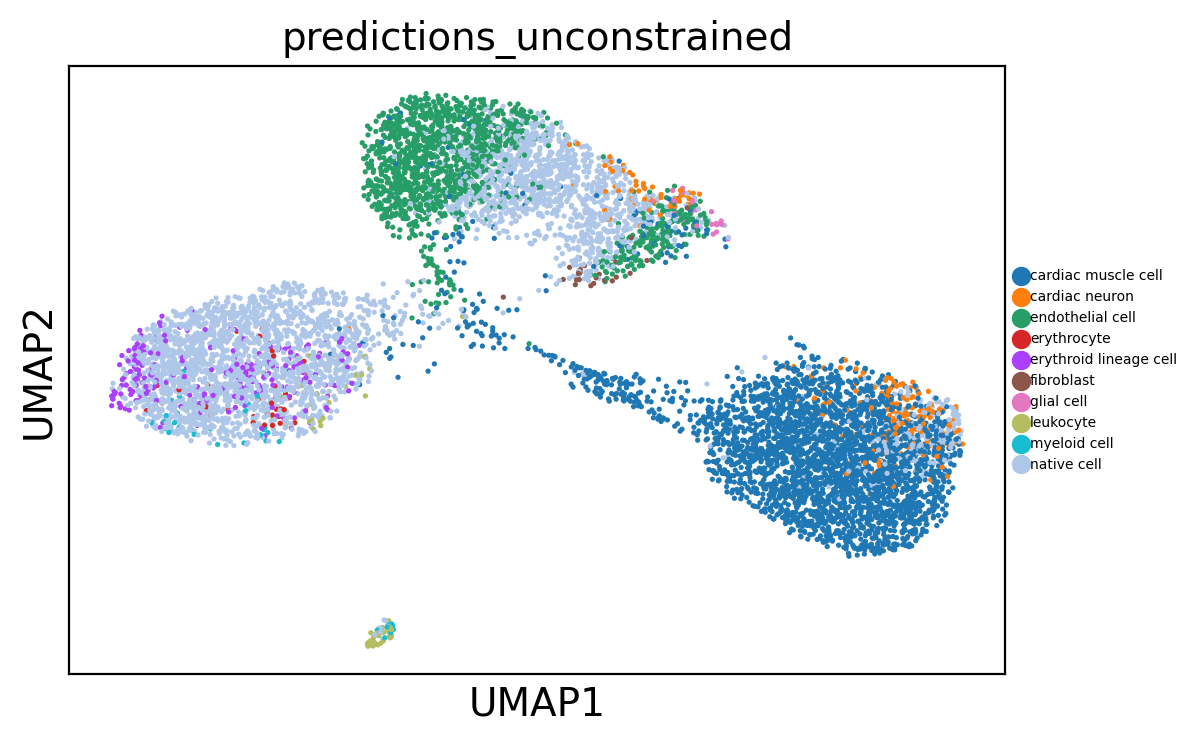

In [19]:
celltype_counts = adams.obs.predictions_unconstrained.value_counts()
well_represented_celltypes = celltype_counts[celltype_counts > 20].index

sc.pl.umap(
    adams[adams.obs.predictions_unconstrained.isin(well_represented_celltypes)],
    color="predictions_unconstrained",
    legend_fontsize=5,
)

In [37]:
# add min_dist to object
adams.obs['min_dist'] = list(nn_stats['min_dist'])

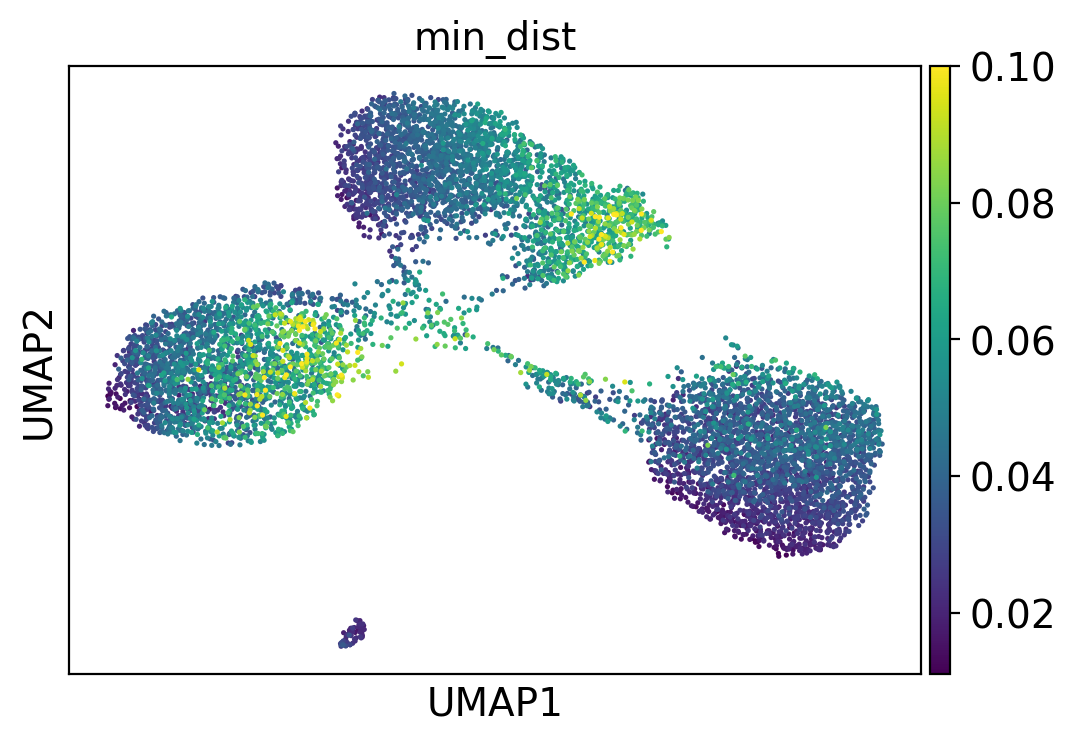

In [38]:
sc.pl.umap(adams, color="min_dist", vmax=0.1)

In [46]:
# save results
nn_stats['predicted_id'] = list(adams.obs.predictions_unconstrained)
nn_stats['barcode'] = list(adams.obs.index)

In [56]:
nn_stats.to_csv('annotations/stage23_sample3_scimilarity_celltypes.csv')